In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Placement

In [7]:
# kolecko_4_enter_50_10000_popsize_50_order_inversion_20240910215106.npz
# kolecko_2_enter_50_10000_popsize_50_order_inversion_20240911160837
res = np.load('../results/doubeline_4_enter_50_10000_popsize_50_order_inversion_20240911165052.npz', allow_pickle=True)
layout_name = res['layout']
bsf_costs = np.min(res['bsf_costs'], axis=1)
pop_size = res['population_size']
machine_positions = res['machine_positions']
drug_names = res['machines_drug_names']

inlet_positions = res['inlet_positions']

gen_best_cost = res['gen_best_cost']
gen_best_perm = res['gen_best_perm'] # permutation of idxs of machines_drug_names
n_eval = res['n_eval']

final_populations = res['final_population']

# Added 2024-09-10
best_perm_per_iteration = res['best_perm_per_iteration']
all_possible_positions = res['all_posible_positions']
chromosome = res['chromosome']
size_x_y = res['size_x_y']

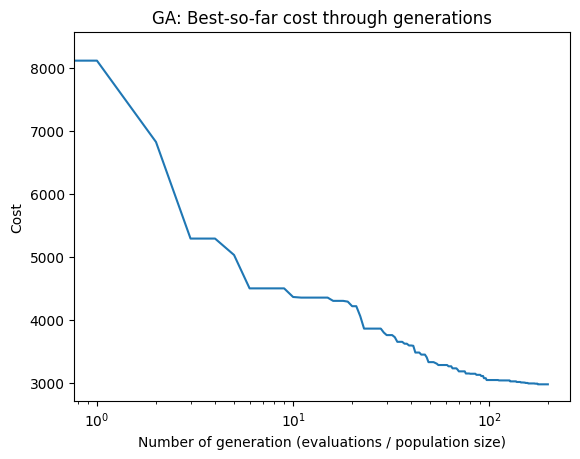

In [8]:
plt.plot(bsf_costs, label='Best cost')
plt.xscale('log')
plt.title('GA: Best-so-far cost through generations')
plt.xlabel('Number of generation (evaluations / population size)')
plt.ylabel('Cost')
plt.show()

In [9]:
def display_placement(permutation, drug_names, machine_positions, inlet_positions):
    fig = plt.figure()
    ax = fig.add_subplot()
    # max size of x in machine_positions
    COORDINATE_X = max([x for x, y in machine_positions]) + 1
    COORDINATE_Y = max([y for x, y in machine_positions]) + 1
    restricted_area = np.zeros((COORDINATE_X, COORDINATE_Y))
    for i in range(len(machine_positions)):
        x, y = machine_positions[i]
        restricted_area[x, y] = 1
    for i in range(len(inlet_positions)):
        x, y = inlet_positions[i]
        restricted_area[x, y] = 2
    ax.imshow(restricted_area.transpose(), cmap='gray', alpha=0.1)
    
    plt.scatter(*zip(*machine_positions), c='r', s=100, marker='s', label='Machine')
    for p in inlet_positions:
        plt.scatter(*zip(p), c='b', s=100, marker='o', label='Exit')

    # ax.set_xticks(range(COORDINATE_X))
    # ax.set_yticks(range(COORDINATE_Y))

    for i in range(len(permutation)):
        drug_name = drug_names[int(permutation[i])]
        x = machine_positions[i][0]
        y = machine_positions[i][1]
        if x == 0: # left
            ha = 'right'
            rotation = 0
            va = 'center'
        elif x == COORDINATE_X-1: # right
            # print(x, y)
            ha = 'left'
            rotation = 0
            va = 'center'
        elif y == COORDINATE_Y-1: # bottom
            ha = 'center'
            rotation = 90
            va = 'top'
        else: # top
            ha = 'center'
            rotation = 90
            va = 'bottom'
            
        ax.text(x, y, drug_name, ha=ha, va=va, rotation=rotation)
    # plt.legend() # Uncomment to show legend. It's overlapping with the text, so I commented it out.
    plt.show()

## Best solution

Best cost: [2979.54568177]


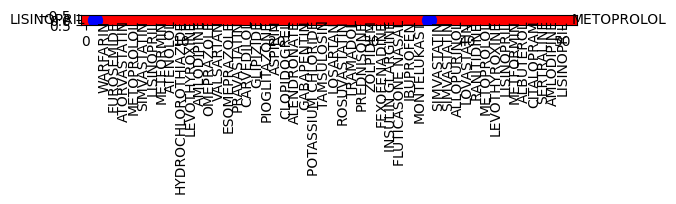

In [10]:
print('Best cost:', gen_best_cost)
display_placement(gen_best_perm, drug_names, machine_positions, inlet_positions)

## Best solution in X-th generation 

Best cost of generation 199: 1559.328150753906


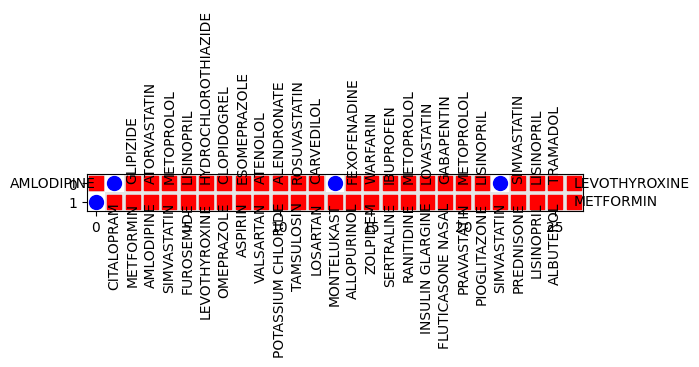

In [19]:
generation_idx = 199 # write here the generation index you want to display
generation_idx = min(generation_idx, int(n_eval/ pop_size) - 1)

all_possible_positions = [tuple(pos) for pos in all_possible_positions]
best_cost_in_gen_idx = np.argmin(res['bsf_costs'][generation_idx])
print(f'Best cost of generation {generation_idx}:', bsf_costs[generation_idx])
machine_count = len(machine_positions)
perm_total = best_perm_per_iteration[generation_idx][best_cost_in_gen_idx]
idx_of_outlets = np.where(chromosome[perm_total.astype(int)] == -10)[0]
inlet_positions = np.array(all_possible_positions)[idx_of_outlets]
inlet_positions_as_tuples = [tuple(i) for i in inlet_positions]

gen_perm = perm_total[perm_total < machine_count]
machines_positions_for_generation=[pos for pos in all_possible_positions if pos not in inlet_positions_as_tuples]
inlets_positions_for_generation = np.array(all_possible_positions)[idx_of_outlets]

display_placement(gen_perm, drug_names, machines_positions_for_generation, inlets_positions_for_generation)

# Generate patients with different capsule dosages


In [1]:
NUMBER_OF_PATIENTS = 100
DISPENSER_SPEED = 10 # tablets per second
TIME_BETWEEN_CAPSULES = 1 # seconds
NUMBER_OF_CAPSULES_PER_MOVER = 100

In [5]:
import pandas as pd
import numpy as np
dosages = pd.read_csv('../drugs_dosing.csv', sep=';')
dosages = dosages[['Drug Names', 'MIN units [pcs]', 'MAX units [pcs]']]


In [6]:
capsules = pd.read_csv('../capsules_with_freq.csv', sep=';')
capsules['exact_exposure_count'] = capsules['exact_exposure_count'].replace('<100', 100).astype(int)
capsules['drug_names'] = capsules['drug_names'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', ')).apply(lambda x: [y.upper() for y in x])

capsules = capsules[['SEQN', 'drug_names', 'exact_exposure_count']]

# take randomly 50 capsules (can be same) based on exact_exposure_count column
capsules = capsules.sample(n=NUMBER_OF_PATIENTS, weights='exact_exposure_count', replace=True)

In [7]:
def generate_dosages(row):
    drugs = row['drug_names']
    generated_dosages = []
    for drug in drugs:
        min_dosage = dosages[dosages['Drug Names'] == drug]['MIN units [pcs]'].values[0]
        max_dosage = dosages[dosages['Drug Names'] == drug]['MAX units [pcs]'].values[0]
        generated_dosages.append(np.random.randint(min_dosage, max_dosage))
    return generated_dosages

# Number of tablets for each drug in each capsule
capsules['dosages'] = capsules.apply(generate_dosages, axis=1)
res_capsules = capsules[['SEQN', 'drug_names', 'dosages']]

In [8]:
# čas strávený dávkováním je dán:
# počtem tablet a konstantní dávkovací rychlostí (600 tablet/min) + 1sec posun mezi kapslemi.
def calculate_time_for_filling_100_capsules(tablets_num):
    return tablets_num * DISPENSER_SPEED * NUMBER_OF_CAPSULES_PER_MOVER + TIME_BETWEEN_CAPSULES * (NUMBER_OF_CAPSULES_PER_MOVER-1)

res_capsules['time (sec)'] = res_capsules['dosages'].apply(lambda x: [calculate_time_for_filling_100_capsules(dosage) for dosage in x])

In [9]:
res_capsules

,SEQN,drug_names,dosages,time (sec)
463,56998,"[FUROSEMIDE, LISINOPRIL, METOPROLOL]","[19, 4, 16]","[19099, 4099, 16099]"
891,61948,"[GLIPIZIDE, LISINOPRIL, METFORMIN]","[7, 6, 11]","[7099, 6099, 11099]"
362,55848,"[LISINOPRIL, METFORMIN, SIMVASTATIN]","[10, 16, 13]","[10099, 16099, 13099]"
362,55848,"[LISINOPRIL, METFORMIN, SIMVASTATIN]","[10, 10, 1]","[10099, 10099, 1099]"
765,60370,"[CARVEDILOL, FUROSEMIDE, LISINOPRIL]","[6, 12, 13]","[6099, 12099, 13099]"
...,...,...,...,...
318,55212,"[ATENOLOL, HYDROCHLOROTHIAZIDE, SIMVASTATIN]","[18, 10, 10]","[18099, 10099, 10099]"
406,56393,"[CARVEDILOL, FUROSEMIDE, LISINOPRIL]","[7, 19, 5]","[7099, 19099, 5099]"
51,52262,"[HYDROCHLOROTHIAZIDE, LISINOPRIL, SIMVASTATIN]","[12, 5, 4]","[12099, 5099, 4099]"
26,51993,"[HYDROCHLOROTHIAZIDE, LISINOPRIL, SIMVASTATIN]","[9, 10, 15]","[9099, 10099, 15099]"


In [10]:
res_capsules.to_csv('generated_capsules_with_dosages.csv', sep=';', index=False)